<h1>1.Single Weight Generation Implementation:</h1>

<h4>1.1.Frozen Base Model without Top Dense Layer</h4>

In [6]:
# https://stackoverflow.com/questions/43867032/how-to-fine-tune-resnet50-in-keras
from keras.applications.vgg16 import VGG16

# create the base pre-trained model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(640,640,3), pooling='Max')

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 640, 640, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 160, 160, 128)     0         
__________

<h4>1.2.Single Image Read and Weight Calculation</h4>

In [7]:
import keras
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

# Image Path
img_path = 'orange/object.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

# Feature Extraction
b2 = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling='Max')
res = b2.predict(x)
object_features = np.reshape(res, (7,7,512,1))
print(object_features.shape)

(1, 224, 224, 3)
(7, 7, 512, 1)


<h4>1.3.Single Image Read and Convolve with Pre-calculated Object Image Weights to Generate Similarity Heat Map</h4>

In [8]:
img_path = 'orange/ds(2).jpg'
img = image.load_img(img_path, target_size=(640, 640))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

model = Sequential([base_model])
def init_f(shape):
    ker=object_features
    return ker

model.add(Conv2D(filters=1, kernel_size=(7,7), kernel_initializer=init_f))
corr = np.squeeze(model.predict(x))
print(corr.shape)
np.sum(corr)

(14, 14)


101390960.0

In [ ]:
model.evaluate(np.array(X_test), np.array(y_test), batch_size=1)

<h1>2.Wiring Everything We Tested:</h1>

<h4>2.1.Code</h4>

In [2]:
import csv
from sklearn.model_selection import train_test_split
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, merge
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.optimizers import SGD
import keras
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.callbacks import LambdaCallback
from keras.layers import BatchNormalization
from keras.layers import multiply


X = []
y = []

# Read Toy Dataset
with open('potato/labels.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        img = image.load_img('potato/'+row['file_name'], target_size=(640, 640))
        im = image.img_to_array(img)
        im = preprocess_input(im)
        y.append(int(row['label']))
        X.append(im)
        
# Split to train and test for Fine-Tuning
# (We will also use test set to calculate full model accuracy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(np.array(X_train).shape)

# Build Network
# Create the base pre-trained VGG16 model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(640, 640,3), pooling='Max')
for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential([base_model])

# Convolution Layer Build Function
def build_conv_layer(object_file, number_of_augmentation):
    dense_outputs = []
    # prepare data augmentation configuration
    object_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
    # Image Read
    img_path = 'potato/object.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    im = image.img_to_array(img)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)

    i = 0
    # Create dense layers as many as number of augmentation
    for aug in object_datagen.flow(im, batch_size=1):
        # Calculate object features for given augmentation
        b2 = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling='Max')
        res = b2.predict(im)
        object_features = np.reshape(res, (7,7,512,1))

        # Kernel Initializer
        def init_f(shape):
            # Pass object features as kernel
            return object_features

        i += 1
        if i > number_of_augmentation:
            break
        from keras.callbacks import LambdaCallback
        conv = Conv2D(filters=1, kernel_size=(7,7), kernel_initializer=init_f)(base_model.layers[-1].output)
        norm = BatchNormalization()(conv)
        mx = (MaxPooling2D(pool_size=(7, 7), padding='same'))(norm)
        fl = Flatten()(mx)
        dense_outputs.append(fl)
    output = multiply(dense_outputs)
    output = Dense(10, activation='relu')(output)
    output = Dropout(0.001)(output)
    output = Dense(1, activation='sigmoid')(output)
    return output

# Merge of convolution results, Fine tuning
model = Model(base_model.layers[0].input, output=build_conv_layer('potato/object.jpg', 16))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

# fine-tune the model for classification
history = model.fit(np.array(X_train), np.array(y_train),batch_size=2, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))


(164, 640, 640, 3)


C:\Users\basar\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 640, 640, 64) 1792        input_19[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 640, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 320, 320, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

Train on 164 samples, validate on 42 samples
Epoch 1/50
164/164 [==============================] - 54s 332ms/step - loss: 8.7160 - acc: 0.3780 - val_loss: 7.6240 - val_acc: 0.5238
Epoch 2/50
164/164 [==============================] - 53s 320ms/step - loss: 7.4637 - acc: 0.4756 - val_loss: 6.7986 - val_acc: 0.5000
Epoch 3/50
164/164 [==============================] - 53s 322ms/step - loss: 7.2832 - acc: 0.4573 - val_loss: 5.2634 - val_acc: 0.5000
Epoch 4/50
164/164 [==============================] - 54s 326ms/step - loss: 7.8185 - acc: 0.4207 - val_loss: 4.5324 - val_acc: 0.5476
Epoch 5/50
164/164 [==============================] - 54s 330ms/step - loss: 6.7890 - acc: 0.4939 - val_loss: 3.1615 - val_acc: 0.6429
Epoch 6/50
164/164 [==============================] - 54s 331ms/step - loss: 6.2787 - acc: 0.5488 - val_loss: 2.9019 - val_acc: 0.6667
Epoch 7/50
164/164 [==============================] - 55s 338ms/step - loss: 6.7853 - acc: 0.5183 - val_loss: 2.7699 - val_acc: 0.6905
Epoch 8/50

In [ ]:
import pydot
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

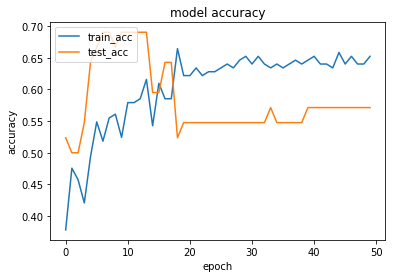

In [3]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc'], loc='upper left')
plt.show()

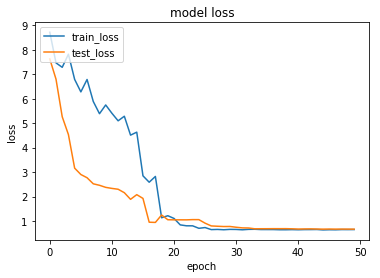

In [4]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.show()